#### Code used to examine precipitation and wind speeds in WRF output files

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from wrf import to_np, getvar, CoordPair, vertcross, latlon_coords, interplevel
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import glob
import wrf
from netCDF4 import Dataset
import matplotlib.pyplot as plt

import metpy.calc as mpcalc
from metpy.plots import Hodograph, SkewT
from metpy.units import units
import matplotlib.gridspec as gridspec
import imageio

#Acceleration of gravity (constant) for converting to geopotential height
g = 9.8

#Latitude of first cross section point
lat1 = 43.0
#lat1 = 31.0

#Longitude of first cross section point
lon1 = -88.0
#lon1 = -81.0

# Latitude of second cross section point
lat2 = 42.5
#lat2 = 33.0

#Longitude of second cross section point
lon2 = -87.0
#lon2 = -79.0

data_ctrl = Dataset("/scratch/legetker/wdm_ctrl_run/wrfout_d02_1998-06-01_00:00:00", "r", format="NETCDF4")
data_1deg = Dataset("/scratch/legetker/wdm_1deg_delta/wrfout_d02_1998-06-01_00:00:00", "r", format="NETCDF4")
data_2deg = Dataset("/scratch/legetker/wdm_2deg_delta/wrfout_d02_1998-06-01_00:00:00", "r", format="NETCDF4")
data_4deg = Dataset("/scratch/legetker/wdm_4deg_delta/wrfout_d02_1998-06-01_00:00:00", "r", format="NETCDF4")

In [2]:
"""
Calculating total rainfall over the course of the day on May 31st, 1998, for control run and each experimental run.
"""

data_ctrl_start = Dataset("/scratch/legetker/wdm_ctrl_run/wrfout_d02_1998-05-31_00:00:00", "r", format="NETCDF4")
data_1deg_start = Dataset("/scratch/legetker/wdm_1deg_delta/wrfout_d02_1998-05-31_00:00:00", "r", format="NETCDF4")
data_2deg_start = Dataset("/scratch/legetker/wdm_2deg_delta/wrfout_d02_1998-05-31_00:00:00", "r", format="NETCDF4")
data_4deg_start = Dataset("/scratch/legetker/wdm_4deg_delta/wrfout_d02_1998-05-31_00:00:00", "r", format="NETCDF4")

lat_lon = [43.17111, -86.23685]
x_y = wrf.ll_to_xy(data_ctrl, lat_lon[0], lat_lon[1])
#x_y_1deg = wrf.ll_to_xy(data_1deg, lat_lon[0], lat_lon[1])
#x_y_2deg = wrf.ll_to_xy(data_2deg, lat_lon[0], lat_lon[1])
#x_y_4deg = wrf.ll_to_xy(data_4deg, lat_lon[0], lat_lon[1])

wdspd_ctrl = getvar(data_ctrl, "RAINNC").values
print(wdspd_ctrl.shape)
wdspd_1deg = getvar(data_1deg, "RAINNC").values
wdspd_2deg = getvar(data_2deg, "RAINNC").values
wdspd_4deg = getvar(data_4deg, "RAINNC").values

wdspd_ctrl = wdspd_ctrl[x_y[0],x_y[1]]
wdspd_1deg = wdspd_1deg[x_y[0],x_y[1]]
wdspd_2deg = wdspd_2deg[x_y[0],x_y[1]]
wdspd_4deg = wdspd_4deg[x_y[0],x_y[1]]

wdspd_ctrl_start = getvar(data_ctrl_start, "RAINNC").values
wdspd_1deg_start = getvar(data_1deg_start, "RAINNC").values
wdspd_2deg_start = getvar(data_2deg_start, "RAINNC").values
wdspd_4deg_start = getvar(data_4deg_start, "RAINNC").values

wdspd_ctrl_start = wdspd_ctrl_start[x_y[0],x_y[1]]
wdspd_1deg_start = wdspd_1deg_start[x_y[0],x_y[1]]
wdspd_2deg_start = wdspd_2deg_start[x_y[0],x_y[1]]
wdspd_4deg_start = wdspd_4deg_start[x_y[0],x_y[1]]

#print out difference between start of day and end of day
print(wdspd_ctrl_start - wdspd_ctrl)
print(wdspd_1deg_start - wdspd_1deg)
print(wdspd_2deg_start - wdspd_2deg)
print(wdspd_4deg_start - wdspd_4deg)


(276, 378)
-31.936283
-39.589775
-43.268906
-43.094006


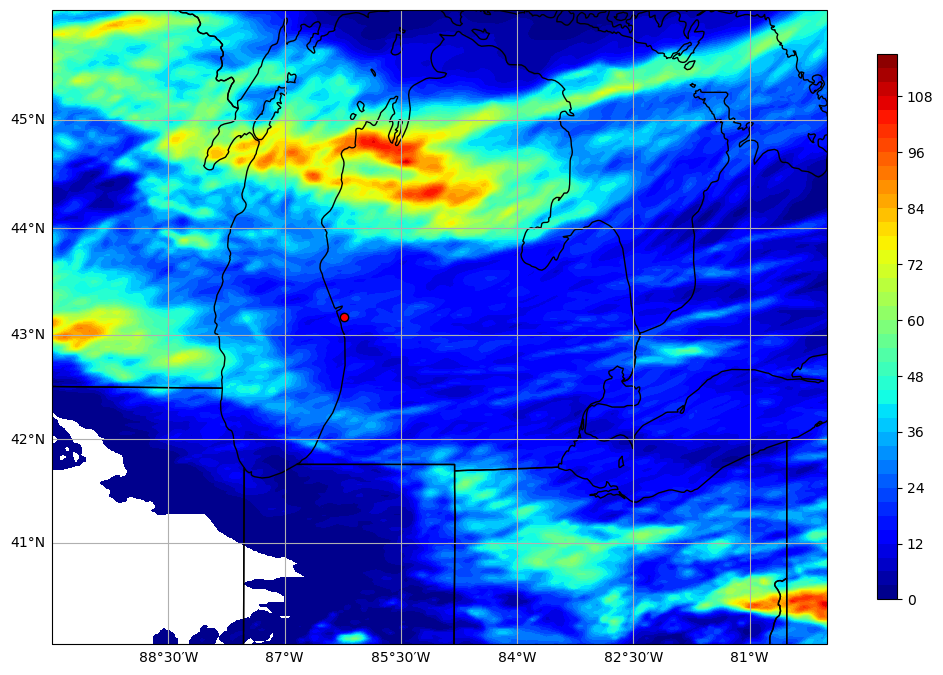

In [9]:
"""
Plot control rainfall and airport location
"""
wdspd_ctrl = getvar(data_ctrl, "RAINNC")
lats, lons = latlon_coords(wdspd_ctrl)
time=wrf.extract_times(data_ctrl, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
timestr=(str(time))
titletime=(timestr[0:10]+' '+timestr[11:16])
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator(central_longitude = 0))
ax.add_feature(cfeature.STATES, edgecolor='black')  #Add US states
ax.add_feature(cfeature.COASTLINE, edgecolor='black')  #Add coastlines
cs = ax.contourf(lons, lats, wdspd_ctrl - wdspd_ctrl_start, cmap = "jet", levels = np.arange(0, 120, 3), transform=ccrs.PlateCarree())
ax.scatter(lat_lon[1], lat_lon[0], color = 'white', transform=ccrs.PlateCarree(), edgecolors = 'black', facecolor = 'red')
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])  #You can change the numbers to move the colorbar.
cbar = plt.colorbar(cs, cax = cax)
ax.set_extent([-90, -80, 40, 46])
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False   # suppress top grid labels
gl.right_labels=False # suppress right grid labels

In [10]:
"""
Find max wind speeds at the given times for each WRF run
"""
data_ctrl = Dataset("/scratch/legetker/wdm_ctrl_run/wrfout_d02_1998-05-31_06:00:00", "r", format="NETCDF4")
data_1deg = Dataset("/scratch/legetker/wdm_1deg_delta/wrfout_d02_1998-05-31_06:00:00", "r", format="NETCDF4")
data_2deg = Dataset("/scratch/legetker/wdm_2deg_delta/wrfout_d02_1998-05-31_06:00:00", "r", format="NETCDF4")
data_4deg = Dataset("/scratch/legetker/wdm_4deg_delta/wrfout_d02_1998-05-31_06:00:00", "r", format="NETCDF4")

lat_lon = [43.5, -86.3]
x_y = wrf.ll_to_xy(data_ctrl, lat_lon[0], lat_lon[1])
#x_y_1deg = wrf.ll_to_xy(data_1deg, lat_lon[0], lat_lon[1])
#x_y_2deg = wrf.ll_to_xy(data_2deg, lat_lon[0], lat_lon[1])
#x_y_4deg = wrf.ll_to_xy(data_4deg, lat_lon[0], lat_lon[1])

wdspd_ctrl = getvar(data_ctrl, "wspd_wdir").values[0]
wdspd_1deg = getvar(data_1deg, "wspd_wdir").values[0]
wdspd_2deg = getvar(data_2deg, "wspd_wdir").values[0]
wdspd_4deg = getvar(data_4deg, "wspd_wdir").values[0]
"""
wdspd_ctrl = wdspd_ctrl[:,x_y[0],x_y[1]]
wdspd_1deg = wdspd_1deg[:,x_y[0],x_y[1]]
wdspd_2deg = wdspd_2deg[:,x_y[0],x_y[1]]
wdspd_4deg = wdspd_4deg[:,x_y[0],x_y[1]]
print(wdspd_ctrl)
"""
print(np.max(wdspd_ctrl[0]))
print(np.max(wdspd_1deg[0]))
print(np.max(wdspd_2deg[0]))
print(np.max(wdspd_4deg[0]))

31.821785
33.363266
36.533268
31.175896


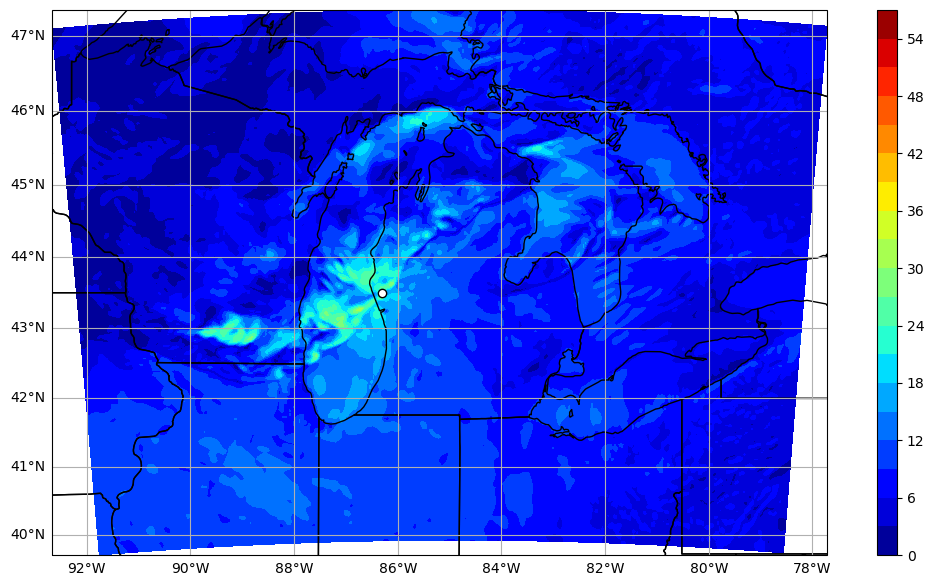

In [11]:
"""
Plot control wind speed and airport location
"""
wdspd_ctrl = getvar(data_ctrl, "wspd_wdir").values[0]
time=wrf.extract_times(data_ctrl, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
timestr=(str(time))
titletime=(timestr[0:10]+' '+timestr[11:16])
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator(central_longitude = 0))
ax.add_feature(cfeature.STATES, edgecolor='black')  #Add US states
ax.add_feature(cfeature.COASTLINE, edgecolor='black')  #Add coastlines
cs = ax.contourf(lons, lats, wdspd_ctrl[0,:,:], cmap = "jet", levels = np.arange(0, 60, 3), transform=ccrs.PlateCarree())
ax.scatter(lat_lon[1], lat_lon[0], color = 'white', transform=ccrs.PlateCarree(), edgecolors = 'black')
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])  #You can change the numbers to move the colorbar.
cbar = plt.colorbar(cs, cax = cax)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.top_labels=False   # suppress top grid labels
gl.right_labels=False # suppress right grid labels

In [12]:
"""
Calculate max wind speeds at every time step
"""
files_ctrl = sorted(glob.glob("/scratch/legetker/wdm_ctrl_run/wrfout_d02*"))
files_1deg = sorted(glob.glob("/scratch/legetker/wdm_1deg_delta/wrfout_d02*"))
files_2deg = sorted(glob.glob("/scratch/legetker/wdm_2deg_delta/wrfout_d02*"))
files_4deg = sorted(glob.glob("/scratch/legetker/wdm_4deg_delta/wrfout_d02*"))



max_ctrl = []
max_1deg = []
max_2deg = []
max_4deg = []
times = []
for i in range(len(files_ctrl) - 12):
    
    data_ctrl = Dataset(files_ctrl[i], "r", format="NETCDF4")
    data_1deg = Dataset(files_1deg[i], "r", format="NETCDF4")
    data_2deg = Dataset(files_2deg[i], "r", format="NETCDF4")
    data_4deg = Dataset(files_4deg[i], "r", format="NETCDF4")
    
    time=wrf.extract_times(data_ctrl, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    times.append(time)
    
    spd_ctrl = wdspd = getvar(data_ctrl, "wspd_wdir").values[0,0,:,:]
    spd_1deg = wdspd = getvar(data_1deg, "wspd_wdir").values[0,0,:,:]
    spd_2deg = wdspd = getvar(data_2deg, "wspd_wdir").values[0,0,:,:]
    spd_4deg = wdspd = getvar(data_4deg, "wspd_wdir").values[0,0,:,:]
    
    max_ctrl.append(np.max(spd_ctrl) * 1.94)
    max_1deg.append(np.max(spd_1deg) * 1.94)
    max_2deg.append(np.max(spd_2deg) * 1.94)
    max_4deg.append(np.max(spd_4deg) * 1.94)
    
print(max_ctrl)
    

[26.374472579956056, 28.521784992218016, 28.417169494628904, 27.08909568786621, 26.372143268585205, 26.44537874221802, 25.13942506790161, 24.0436940574646, 24.07487796783447, 31.655833663940427, 30.2837638092041, 22.442879905700682, 19.03453493118286, 20.61810773849487, 25.86833116531372, 27.546047744750975, 31.11194408416748, 23.312508602142334, 25.035880794525145, 32.98652355194092, 51.56262077331543, 56.805436286926266, 60.670194931030274, 47.08400810241699, 33.44845245361328, 33.481018409729, 56.26143939971924, 64.44301330566407, 61.12623672485351, 64.81152183532714, 61.73426284790039, 61.74621837615967, 55.196172599792476, 58.64541835784912, 68.53369110107421, 51.0806549835205, 43.5065669631958, 50.94225059509277, 64.63041648864746, 46.84360984802246, 60.991902618408204, 65.64310264587402, 34.51964336395264, 48.31984191894531, 59.05485912322998, 78.80304214477539, 65.19315147399902, 62.34407989501953, 53.13381622314453, 40.391853981018066, 35.61969627380371, 34.64318382263183, 30.

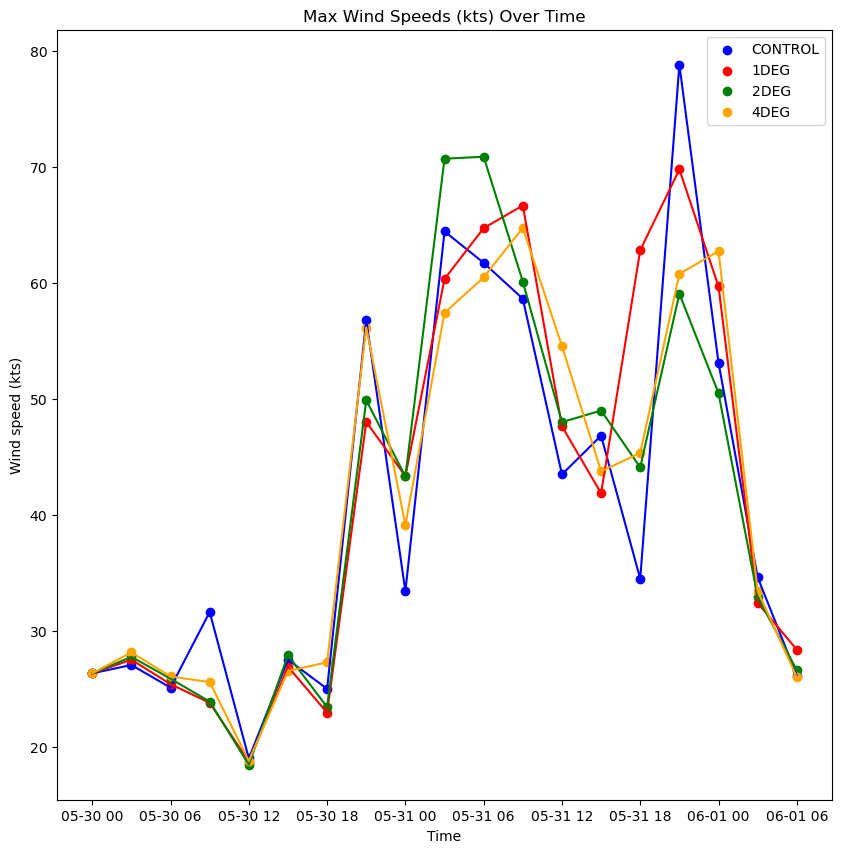

In [13]:
"""
Plot max wind speeds at every time step, staggered every three hours
"""
fig = plt.figure(figsize=(10,10))
ax = plt.axes()

plt.scatter(times[0::3], max_ctrl[0::3], label = "CONTROL", color = "blue")
plt.plot(times[0::3], max_ctrl[0::3], color = "blue")

plt.scatter(times[0::3], max_1deg[0::3], label = "1DEG", color = "red")
plt.plot(times[0::3], max_1deg[0::3], color = "red")

plt.scatter(times[0::3], max_2deg[0::3], label = "2DEG", color = "green")
plt.plot(times[0::3], max_2deg[0::3], color = "green")

plt.scatter(times[0::3], max_4deg[0::3], label = "4DEG", color = "orange")
plt.plot(times[0::3], max_4deg[0::3], color = "orange")

plt.title("Max Wind Speeds (kts) Over Time")
plt.xlabel("Time")
plt.ylabel("Wind speed (kts)")
plt.legend()

In [14]:
"""
Calculate mean of max wind speeds
"""
print(np.mean(max_ctrl))
print(np.mean(max_1deg))
print(np.mean(max_2deg))
print(np.mean(max_4deg))

42.599689568953075
43.48377368684248
43.01655462958596
42.92180684107
